# Develop my own package

## 2-Point Correlation Function

### The 2-point correlation function, ξ(θ), is a statistical tool used in astronomy to quantify the clustering of galaxies. It measures the excess probability of finding a pair of galaxies separated by an angle θ compared to a random distribution.


In [12]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import treecorr
#import arviz as az
#import pandas as pd
#import pymc as pm
%matplotlib inline
import halomod as hm
import hmf


#%matplotlib inline
#plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':64})
## for Palatino and other serif fonts use:
#plt.rc('font',**{'family':'serif','size':18})
#plt.rc('text', usetex=True)

In [13]:
home_dir = os.path.expanduser('~')
# Construct the path to the "Thesis" directory on the desktop
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')


fits_file_path = os.path.join(thesis_path, "table")  


t= Table.read(fits_file_path)

#t= t[::5]  # Making sample smaller so my computer can handle it

t

id_1,ra,dec,fof_id,fof_size,mask_flags,flags,flagstr,badpix_frac,psf_g_0,psf_g_1,psf_T,bdf_T,bdf_T_err,bdf_T_ratio,bdf_g_0,bdf_g_1,bdf_fracdev,bdf_fracdev_err,tilename,EBV_SFD98,mask_flags_nir,flags_nir,flagstr_nir,badpix_frac_nir,psf_flux_u,psf_flux_g,psf_flux_r,psf_flux_i,psf_flux_z,psf_flux_J,psf_flux_H,psf_flux_Ks,psf_flux_err_u,psf_flux_err_g,psf_flux_err_r,psf_flux_err_i,psf_flux_err_z,psf_flux_err_J,psf_flux_err_H,psf_flux_err_Ks,bdf_flux_u,bdf_flux_g,bdf_flux_r,bdf_flux_i,bdf_flux_z,bdf_flux_J,bdf_flux_H,bdf_flux_Ks,bdf_flux_err_u,bdf_flux_err_g,bdf_flux_err_r,bdf_flux_err_i,bdf_flux_err_z,bdf_flux_err_J,bdf_flux_err_H,bdf_flux_err_Ks,gap_flux_u,gap_flux_g,gap_flux_r,gap_flux_i,gap_flux_z,gap_flux_J,gap_flux_H,gap_flux_Ks,gap_flux_err_u,gap_flux_err_g,gap_flux_err_r,gap_flux_err_i,gap_flux_err_z,gap_flux_err_J,gap_flux_err_H,gap_flux_err_Ks,psf_flux_calib_u,psf_flux_calib_g,psf_flux_calib_r,psf_flux_calib_i,psf_flux_calib_z,psf_flux_calib_J,psf_flux_calib_H,psf_flux_calib_Ks,psf_flux_err_calib_u,psf_flux_err_calib_g,psf_flux_err_calib_r,psf_flux_err_calib_i,psf_flux_err_calib_z,psf_flux_err_calib_J,psf_flux_err_calib_H,psf_flux_err_calib_Ks,bdf_flux_calib_u,bdf_flux_calib_g,bdf_flux_calib_r,bdf_flux_calib_i,bdf_flux_calib_z,bdf_flux_calib_J,bdf_flux_calib_H,bdf_flux_calib_Ks,bdf_flux_err_calib_u,bdf_flux_err_calib_g,bdf_flux_err_calib_r,bdf_flux_err_calib_i,bdf_flux_err_calib_z,bdf_flux_err_calib_J,bdf_flux_err_calib_H,bdf_flux_err_calib_Ks,psf_flux_dered_u,psf_flux_dered_g,psf_flux_dered_r,psf_flux_dered_i,psf_flux_dered_z,psf_flux_dered_J,psf_flux_dered_H,psf_flux_dered_Ks,psf_flux_err_dered_u,psf_flux_err_dered_g,psf_flux_err_dered_r,psf_flux_err_dered_i,psf_flux_err_dered_z,psf_flux_err_dered_J,psf_flux_err_dered_H,psf_flux_err_dered_Ks,bdf_flux_dered_u,bdf_flux_dered_g,bdf_flux_dered_r,bdf_flux_dered_i,bdf_flux_dered_z,bdf_flux_dered_J,bdf_flux_dered_H,bdf_flux_dered_Ks,bdf_flux_err_dered_u,bdf_flux_err_dered_g,bdf_flux_err_dered_r,bdf_flux_err_dered_i,bdf_flux_err_dered_z,bdf_flux_err_dered_J,bdf_flux_err_dered_H,bdf_flux_err_dered_Ks,psf_flux_dered_calib_u,psf_flux_dered_calib_g,psf_flux_dered_calib_r,psf_flux_dered_calib_i,psf_flux_dered_calib_z,psf_flux_dered_calib_J,psf_flux_dered_calib_H,psf_flux_dered_calib_Ks,psf_flux_err_dered_calib_u,psf_flux_err_dered_calib_g,psf_flux_err_dered_calib_r,psf_flux_err_dered_calib_i,psf_flux_err_dered_calib_z,psf_flux_err_dered_calib_J,psf_flux_err_dered_calib_H,psf_flux_err_dered_calib_Ks,bdf_flux_dered_calib_u,bdf_flux_dered_calib_g,bdf_flux_dered_calib_r,bdf_flux_dered_calib_i,bdf_flux_dered_calib_z,bdf_flux_dered_calib_J,bdf_flux_dered_calib_H,bdf_flux_dered_calib_Ks,bdf_flux_err_dered_calib_u,bdf_flux_err_dered_calib_g,bdf_flux_err_dered_calib_r,bdf_flux_err_dered_calib_i,bdf_flux_err_dered_calib_z,bdf_flux_err_dered_calib_J,bdf_flux_err_dered_calib_H,bdf_flux_err_dered_calib_Ks,psf_mag_u,psf_mag_g,psf_mag_r,psf_mag_i,psf_mag_z,psf_mag_J,psf_mag_H,psf_mag_Ks,psf_mag_dered_u,psf_mag_dered_g,psf_mag_dered_r,psf_mag_dered_i,psf_mag_dered_z,psf_mag_dered_J,psf_mag_dered_H,psf_mag_dered_Ks,psf_mag_err_dered_u,psf_mag_err_dered_g,psf_mag_err_dered_r,psf_mag_err_dered_i,psf_mag_err_dered_z,psf_mag_err_dered_J,psf_mag_err_dered_H,psf_mag_err_dered_Ks,psf_mag_dered_calib_u,psf_mag_dered_calib_g,psf_mag_dered_calib_r,psf_mag_dered_calib_i,psf_mag_dered_calib_z,psf_mag_dered_calib_J,psf_mag_dered_calib_H,psf_mag_dered_calib_Ks,bdf_mag_u,bdf_mag_g,bdf_mag_r,bdf_mag_i,bdf_mag_z,bdf_mag_J,bdf_mag_H,bdf_mag_Ks,bdf_mag_dered_u,bdf_mag_dered_g,bdf_mag_dered_r,bdf_mag_dered_i,bdf_mag_dered_z,bdf_mag_dered_J,bdf_mag_dered_H,bdf_mag_dered_Ks,bdf_mag_err_dered_u,bdf_mag_err_dered_g,bdf_mag_err_dered_r,bdf_mag_err_dered_i,bdf_mag_err_dered_z,bdf_mag_err_dered_J,bdf_mag_err_dered_H,bdf_mag_err_dered_Ks,bdf_mag_dered_calib_u,bdf_mag_dered_calib_g,bdf_mag_dered_calib_r,bdf_mag_dered_calib_i,bdf_mag_dered_calib_z,bdf_mag_dered_calib_J,bdf_mag_dered_calib_H,bdf_mag_dered_calib_Ks,kNN_class,z,SM,

In [14]:
"""home_dir = os.path.expanduser('~')

# Construct the path to the "Thesis" directory on the desktop
thesis_path = os.path.join(home_dir, 'Desktop', 'Thesis')


fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  
t= Table.read(fits_file_path)


masked = os.path.join(thesis_path, "SN-C3_masked_cat.fits") 
t3= Table.read(masked)

t=join(t,t3,keys='id')
t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')
"""

fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 

hdulist = fits.open(fits_random)
hdulist.info()

t2= Table.read(fits_random)


Filename: /home/astro/manasoi7/Master_Thesis/DATA/SN-C3_randoms_ugriz_trim_video.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SN-C3_C01_randoms_raw.fits    1 BinTableHDU     18   13402307R x 3C   [E, E, 9A]   


In [15]:
config = {
    'min_sep':  0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'bootstrap'  # or 'jackknife'
}

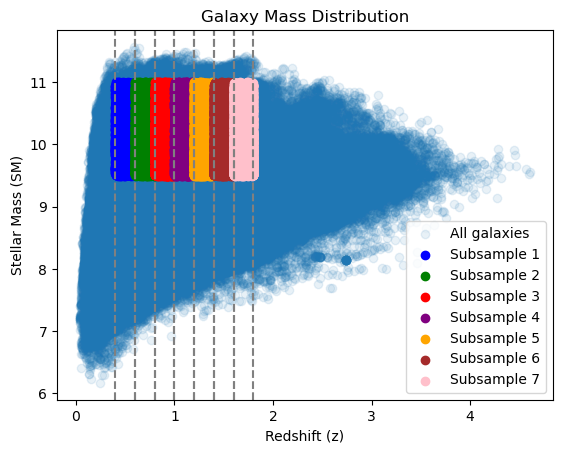

Subsample 1: N = 5410
  z_mean: 0.5
  SM_mean: 10.25
  z_min: 0.4

Subsample 2: N = 8925
  z_mean: 0.7
  SM_mean: 10.25
  z_min: 0.6

Subsample 3: N = 11153
  z_mean: 0.9
  SM_mean: 10.25
  z_min: 0.8

Subsample 4: N = 9890
  z_mean: 1.1
  SM_mean: 10.25
  z_min: 1.0

Subsample 5: N = 10340
  z_mean: 1.2999999999999998
  SM_mean: 10.25
  z_min: 1.2

Subsample 6: N = 7706
  z_mean: 1.5
  SM_mean: 10.25
  z_min: 1.4

Subsample 7: N = 7922
  z_mean: 1.7000000000000002
  SM_mean: 10.25
  z_min: 1.6



In [16]:
class Subsample:
    def __init__(self, z_min, z_max, SM_min, SM_max):
        self.z_min = z_min
        self.z_max = z_max
        self.SM_min = SM_min
        self.SM_max = SM_max
        self.info = {}  # Empty dictionary to store information

        # Add relevant information for R_0 calculation (e.g., delta, A, delta_z)
        self.info['delta'] = None  # Placeholder for delta
        self.info['A'] = None  # Placeholder for A
        # self.info['A'] = np.zeros()
        self.info['delta_z'] = (z_max - z_min)  # Assuming delta_z is the redshift bin width
        
       

    def apply(self, data):
        """
        Selects data points within the subsample region.

        Args:
            data: A dictionary containing data columns like 'z' and 'SM'.

        Returns:
            A boolean mask for the subsample selection.
        """
        return (data['z'] > self.z_min) & (data['z'] <= self.z_max) & \
               (data['SM'] > self.SM_min) & (data['SM'] <= self.SM_max)
    
    
    
# Define z and SM ranges
z_values = np.array([ 0.4,0.6,0.8, 1.0, 1.2, 1.4,1.6,1.8])

SM_range = np.linspace(9.5, 11, num=2) # High SM
#SM_range = np.linspace(8, 9.5, num=2) #Low SM
#SM_range = np.linspace(9, 11, num=3)

# Create subsamples
subsamples = []
z_mean_range = []
SM_mean_range = []

for i in range(len(z_values) - 1):
    z_min = z_values[i]
    z_max = z_values[i + 1]
    z_mean = (z_min + z_max) / 2
    z_mean_range.append(z_mean)

    for j in range(len(SM_range) - 1):
        SM_min = SM_range[j]
        SM_max = SM_range[j + 1]
        SM_mean = (SM_min + SM_max) / 2
        SM_mean_range.append(SM_mean)

        subsample = Subsample(z_min, z_max, SM_min, SM_max)
        subsample.info['z_mean'] = z_mean  # Add z_mean to the info dictionary
        subsample.info['z_min'] = z_min 
        subsample.info['SM_mean'] = SM_mean  # Add SM_mean to the info dictionary
        subsample.info['delta_z'] = (z_max - z_min)  # Assuming delta_z is the redshift bin width
        subsamples.append(subsample)


        
        
plt.scatter(t['z'], t['SM'], label='All galaxies',alpha=0.1)

# Scatter plot with subsample colors
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'yellow', 'cyan', 'black', 'magenta', 'lime', 'olive', 'teal']

for i, subsample in enumerate(subsamples):
    subset = subsample.apply(t)
    z_subsample = t['z'][subset]
    SM_subsample = t['SM'][subset]

    plt.scatter(z_subsample, SM_subsample, label=f'Subsample {i+1}', c=colors[i])

for i in range(len(z_values) - 1):
    z_min = z_values[i]
    z_max = z_values[i + 1]
    plt.axvline(z_min, linestyle='--', color='gray')
    plt.axvline(z_max, linestyle='--', color='gray')

plt.xlabel('Redshift (z)')
plt.ylabel('Stellar Mass (SM)')
plt.title('Galaxy Mass Distribution')
plt.legend()
plt.show()

# Create SkyCoord catalogs for subsamples
catalogs = []

for subsample in subsamples:
    subset = subsample.apply(t)
    catalog = t[subset]
    #catalog = SkyCoord(ra=ra_subset * u.deg, dec=dec_subset * u.deg)
    
    catalogs.append(catalog)

# Print number of galaxies in each subsample
for i, subsample in enumerate(subsamples):
    N = len(catalogs[i])

    print(f"Subsample {i+1}: N = {N}")
    print(f"  z_mean: {subsample.info['z_mean']}")
    print(f"  SM_mean: {subsample.info['SM_mean']}")
    print(f"  z_min: {subsample.info['z_min']}")
    print()

In [17]:
print(len(subsamples))


7


In [18]:

class CorrelationFunction:
    def __init__(self, cat, randoms, config, rr=None):
        self.cat = cat
        self.randoms = randoms
        self.config = config

        # Create TreeCorr catalogs
        self.data = treecorr.Catalog(ra=cat['ra'], dec=cat['dec'], 
                                     ra_units='degrees', dec_units='degrees', npatch=50)
        self.rand = treecorr.Catalog(ra=randoms['ra'], dec=randoms['dec'], 
                                     ra_units='degrees', dec_units='degrees', npatch=50)

        # Create TreeCorr correlation functions
        self.dd = treecorr.NNCorrelation(**config)
        self.rr = treecorr.NNCorrelation(**config)
        self.dr = treecorr.NNCorrelation(**config)
        
    #def process_rand(self):
        #self.rr.process(self.rand) ###????maybe here problem?

    def process(self):
        self.dd.process(self.data)
        self.dr.process(self.data, self.rand)
        self.rr.process(self.rand)

    def calculate_w_theta(self):
        theta = np.exp(self.dd.meanlogr)
        w, varw = self.dd.calculateXi(rr=self.rr, dr=self.dr) 
        
        return w, varw, theta , self.rr
    

    """def power_law(self,theta, A, delta):
        self.A=A
        self.theta=theta
        self.delta= delta
        
        return A * theta**delta"""

In [19]:
"""c1 = CorrelationFunction(catalog, randoms, config)
c1.process()
w, varw, theta, rr = c1.calculate_w_theta()
f1= c1.power_law(theta,0.02,-0.8)"""



'c1 = CorrelationFunction(catalog, randoms, config)\nc1.process()\nw, varw, theta, rr = c1.calculate_w_theta()\nf1= c1.power_law(theta,0.02,-0.8)'

In [20]:
"""plt.plot(theta, f1, label='Power Law Fit')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$w(\theta)$')
plt.title("Power Law Fit for 2PCF")
plt.yscale('log')
plt.xscale('log')
       
plt.show()"""

'plt.plot(theta, f1, label=\'Power Law Fit\')\nplt.xlabel(r\'$\theta$ (degrees)\')\nplt.ylabel(r\'$w(\theta)$\')\nplt.title("Power Law Fit for 2PCF")\nplt.yscale(\'log\')\nplt.xscale(\'log\')\n       \nplt.show()'

In [21]:
"""subsample = (t['z'] > 0.5) & (t['z'] <= 0.6) & (t['SM'] > 10) & (t['SM'] <= 10.5)
subset = t[subsample]
randoms = t2[::1000]

corr_func = CorrelationFunction(subset, randoms, config)


corr_func.process_rand() #crashes here
corr_func.process() # and crashes here too
w, varw, theta, rr = corr_func.calculate_w_theta()


# Save the data to a text file, separating columns with commas
np.savetxt("w.txt", w, delimiter=",")
np.savetxt("varw.txt", w, delimiter=",")
np.savetxt("theta.txt", w, delimiter=",")
np.savetxt("rr.txt", w, delimiter=",")
"""

'subsample = (t[\'z\'] > 0.5) & (t[\'z\'] <= 0.6) & (t[\'SM\'] > 10) & (t[\'SM\'] <= 10.5)\nsubset = t[subsample]\nrandoms = t2[::1000]\n\ncorr_func = CorrelationFunction(subset, randoms, config)\n\n\ncorr_func.process_rand() #crashes here\ncorr_func.process() # and crashes here too\nw, varw, theta, rr = corr_func.calculate_w_theta()\n\n\n# Save the data to a text file, separating columns with commas\nnp.savetxt("w.txt", w, delimiter=",")\nnp.savetxt("varw.txt", w, delimiter=",")\nnp.savetxt("theta.txt", w, delimiter=",")\nnp.savetxt("rr.txt", w, delimiter=",")\n'

In [22]:
randoms = t2
#randoms = t2[::1000]

In [23]:
# Create CorrelationFunction objects with the same configuration
corr_funcs = []

for i, catalog in enumerate(catalogs):
    corr_func = CorrelationFunction(catalog, randoms, config)
    corr_func.process()
    w, varw, theta, rr = corr_func.calculate_w_theta()

    # Append the calculated values to the corresponding subsample's info dictionary
    subsamples[i].info['w'] = w
    subsamples[i].info['varw'] = varw
    subsamples[i].info['theta'] = theta
    subsamples[i].info['rr'] = rr
    corr_funcs.append(corr_func)
  
    
for i, subsample in enumerate(subsamples):
    N = len(catalog)
    print(len(subsamples))

    print(f"Subsample {i+1}: N = {N}")
    print(f"  w: {subsample.info['w']}")

7
Subsample 1: N = 7922
  w: [ 3.81568690e-01  5.07969601e-01  5.06396659e-01  4.10181686e-01
  2.73103698e-01  1.96816527e-01  2.29600975e-01  1.92573654e-01
  2.50631138e-01  3.43982612e-01  1.73216545e-01  1.63494143e-01
  9.25654947e-02  1.91801596e-01  1.40796774e-01  1.28461186e-01
  1.31297934e-01  6.66716308e-02  1.18171877e-01  8.82758878e-02
  7.49495219e-02  5.45382123e-02  5.99681843e-02  5.92760798e-02
  2.00810681e-02  5.33116832e-02  8.48581860e-02  5.24594949e-02
  5.95830055e-02  4.14749252e-02  1.76101208e-02  5.10364696e-02
  3.91561226e-02  8.51320505e-03  3.13503496e-02  2.76953740e-02
  1.91929659e-02  1.49394000e-02  2.78127428e-02  1.53017216e-02
  1.11614553e-02  5.32645724e-03  1.87914280e-03 -1.06470277e-03
  6.69845061e-04  5.09957177e-03 -8.44798054e-05  1.37048306e-03
  4.57869707e-03  3.67042448e-03  9.86803905e-03  5.19633655e-03
 -1.73810154e-03 -4.71211693e-03 -3.47758445e-03 -1.17865266e-03
 -6.03080266e-03 -8.82606549e-03 -1.22396319e-02 -2.70478407e

In [24]:
print(len(subsamples))


7


In [25]:
ws= []
varws= []
thetas= []
results= []
# Process and calculate w(theta) for each subsample
for i, corr_func in enumerate(corr_funcs):
    #w, varw, theta, rr = corr_func.calculate_w_theta()
    ws.append(w)
    varws.append(varw)
    thetas.append(theta)
    
    # Create a dictionary for this iteration
    iteration_results = {
            "w": w,
            "varw": varw,
            "theta": theta}

        # Append the iteration results to the main list
    results.append(iteration_results)


/tmp/ipykernel_251517/2760600179.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


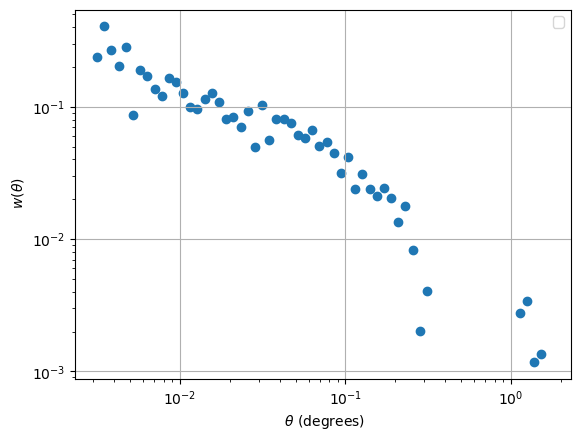

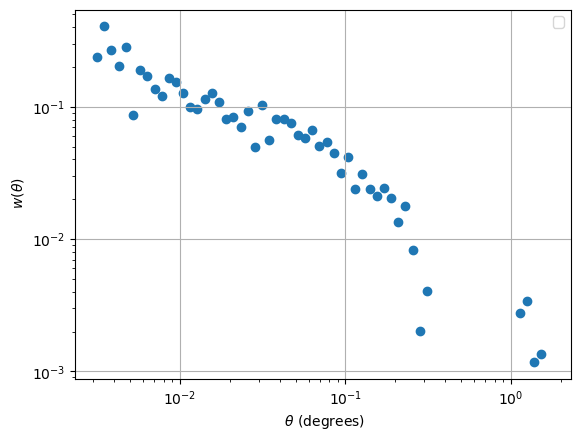

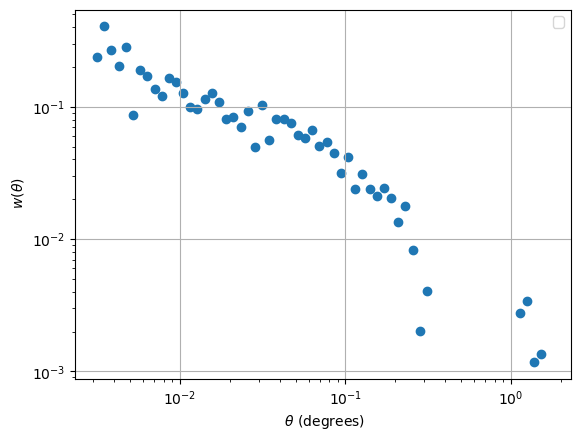

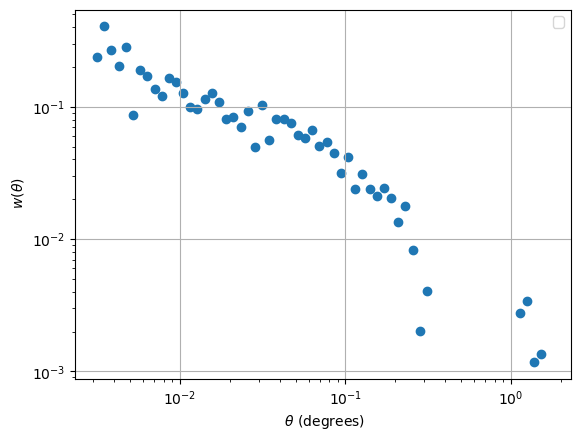

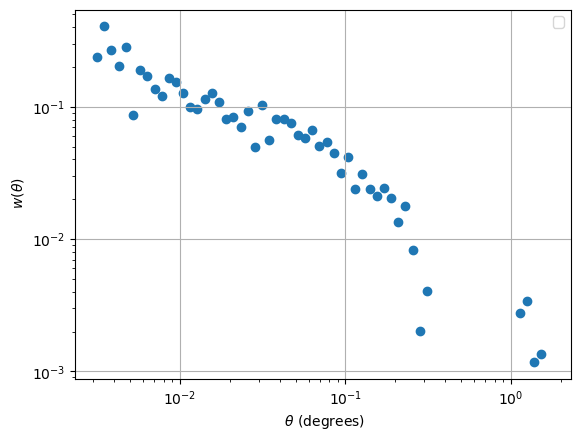

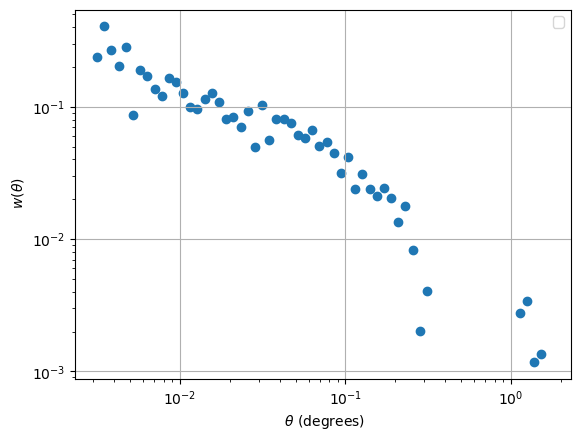

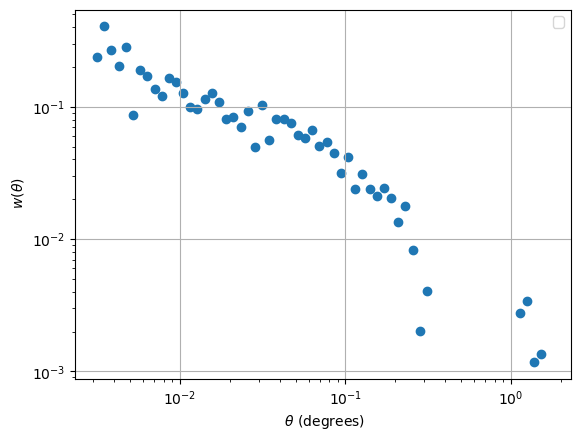

In [26]:
for i, catalog in enumerate(catalogs):
    
    plt.scatter(thetas[i],ws[i])

    plt.xlabel(r' $ \theta$ (degrees)')  #correlation function w
    plt.ylabel(r' $w(\theta)$') # angular separation theta
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)

    plt.show()

In [27]:
fit= corr_func.power_law(theta, A=0.01)
err=np.sqrt(varw)

AttributeError: 'CorrelationFunction' object has no attribute 'power_law'

In [ ]:
for i, catalog in enumerate(catalogs):
    
   # plt.scatter(thetas[i],ws[i])
    plt.scatter(thetas[i],ws[i])

    plt.plot(thetas[i], fit, label='Power law fit')


    plt.xlabel(r' $ \theta$ (degrees)')  #correlation function w
    plt.ylabel(r' $w(\theta)$') # angular separation theta
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)

    plt.show()
cuts=(theta>3e-3) & (theta <1) #define valid values




In [ ]:
"""

def power_law(theta, A, delta):
    return A * theta**delta


def fit_and_plot_power_law(theta, w, cat):
   

    # Fit the power law using curve_fit with initial guesses
    popt, pcov = curve_fit(power_law, theta, w, p0=[2e-2, -0.8])

    # Extract fitted parameters
    A_fit = popt[0]
    delta_fit = popt[1]

    # Calculate amplitude at 1 degree
    amplitude_at_1deg = power_law(1, A_fit, delta_fit)

    # Print fit parameters
    print(f"Subsample {cat}, Power-law Fit Parameters")
    print(f" Amplitude at 1°:", amplitude_at_1deg)
    print()

    return amplitude_at_1deg


    
As = []
for i, catalog in enumerate(catalogs):
    A = fit_and_plot_power_law(thetas[i],ws[i], i + 1)
    
    plt.scatter(thetas[i],ws[i], label=f"Subsample {catalog}")
    plt.plot(thetas[i], power_law(thetas[i], *popt), label='Power Law Fit')
    plt.xlabel(r' $ \theta$ (degrees)')
    plt.ylabel(r' $w(\theta)$')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.show()
    
    subsample.info['Amplitude'] = fit_and_plot_power_law(theta, w, catalog)
    subsamples.append(subsample)
    
    As.append(A)
"""

In [ ]:
print(subsample.info['A'])

In [ ]:
def power_law(theta, A, delta):
    return A * theta**delta


def fit_and_plot_power_law(theta, w, cat):
    """
    Fits a power law to the provided 2PCF data and plots the results.

    Args:
        theta (np.ndarray): Angular separation bins.
        w (np.ndarray): 2PCF values for the current catalog.
        cat (int): Identifier for the current catalog (used for labeling).
    """

    # Fit the power law using curve_fit with initial guesses
    popt, pcov = curve_fit(power_law, theta, w, p0=[2e-2, -0.8])

    # Extract fitted parameters
    A_fit = popt[0]
    delta_fit = popt[1]

    # Calculate amplitude at 1 degree
    amplitude_at_1deg = power_law(1, A_fit, delta_fit)

    # Print fit parameters
    print(f"Subsample {cat}, Power-law Fit Parameters")
    print(f" Amplitude at 1°:", amplitude_at_1deg)
    print(f" Delta:", delta_fit)
    print()

    # Plot the data and fitted curve for this catalog
    plt.scatter(theta, w, label=f"Subsample {cat}")
    plt.plot(theta, power_law(theta, *popt), label='Power Law Fit')

    return amplitude_at_1deg, delta_fit

"""
As = []
for i, catalog in enumerate(catalogs):
    # Call fit_and_plot_power_law to get fit parameters and plot for each catalog
    A = fit_and_plot_power_law(thetas[i], ws[i], i + 1)
    
    As.append(A)"""
    
deltas = []
As = []
for i, catalog in enumerate(catalogs):
    A, delta = fit_and_plot_power_law(thetas[i], ws[i], i + 1)
    As.append(A)
    deltas.append(delta)

# Additional plotting customizations (labels, grid, etc.) can be added here
plt.title("Power law fit")
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.yscale('log')
plt.xscale('log')
plt.savefig("Power law fit")

plt.grid(True)
plt.legend()
plt.show()


In [ ]:
print(subsample.info['A'])

In [ ]:
for subsample in subsamples:
    subsample.A = np.array(As)  # Convert As to a numpy array
    subsample.delta = np.array(deltas)  # Convert deltas to a numpy array


In [ ]:
for subsample in subsamples:
    subsample.info['A'] = np.array(As)  # Convert As to a numpy array
    subsample.info['delta'] = np.array(deltas)  # Convert deltas to a numpy array

In [ ]:
print(subsample.info['A'])
print(subsample.info['delta'])


In [ ]:


print(type(299792.458))
print(type(subsample.A))
print(type(subsample.info['delta_z']))


In [ ]:
class Cosmology:
    def __init__(self, H0, Omega0):
        self.H0 = H0
        self.Omega0 = Omega0

    def x(self, z):
        def integrand(z_prime):
            return ((1 + z_prime)**3 + self.Omega0 - 1)**(-0.5)
        result, _ = quad(integrand, 0, z)
        return result * (self.Omega0**(-0.5) * self.H0)

    def F(self, z):
        return 1

    def P(self, z):
        return np.sqrt(self.Omega0) * np.sqrt((1 + z) ** 3 + self.Omega0**(-1) - 1)

In [ ]:
# class that calculates the comoving correlation length (R_0) for a subsample based on its properties

class SubsampleAnalysis:
    def __init__(self, delta, A, z_mean, delta_z, H_gamma=3.68, c=299792.458):
        self.delta = delta
        self.A = A
        self.z_mean = z_mean
        self.delta_z = delta_z
        self.H_gamma = H_gamma
        self.c = c

        # Assuming a standard cosmology
        self.cosmo = Cosmology(H0=70, Omega0=0.3)

    def calculate_r0(self):
        print(type(self.A))
        gamma = 1.8
        #gamma = (self.delta * -1) + 1
        print(gamma)
        numerator = self.c * self.A * self.delta_z

        denominator = self.cosmo.H0 * self.H_gamma * self.cosmo.x(self.z_mean) ** (1 - gamma) * self.cosmo.P(self.z_mean) * self.cosmo.F(self.z_mean)
        r0 = (numerator / denominator) ** (1 / gamma)
        
        return r0
    
    
     

In [ ]:
print("Subsample A values:")
for a_value in subsample.info['A']:
        print(a_value)  # Print each element of the A array

In [ ]:
r0_values = []
for subsample in subsamples:
    # Create a SubsampleAnalysis object with relevant information
    analysis = SubsampleAnalysis(subsample.info['delta'], subsample.info['A'],
                                  subsample.info['z_mean'], subsample.info['delta_z'] ,3.68, 299792.458)

    # Calculate R_0 for the subsample
    r0 = analysis.calculate_r0()
    #r0_values.append(r0)
    
    r0_value = r0[0]  # Assuming r0 is a 1D array, access the first element
    r0_values.append(r0_value)

    # Print or store the R_0 value (optional)
    print(f"Subsample: R_0: {r0_value:.4f} Mpc/h")

    # Print or store the R_0 value (optional)
    #print(f"Subsample: R_0: {r0:.4f} Mpc/h")

    # Extract z_mean and R_0 values from the subsamples
    z_means = [subsample.info['z_mean'] for subsample in subsamples]
    sm_means = [subsample.info['SM_mean'] for subsample in subsamples]


In [ ]:
z_means = [subsample.info['z_mean'] for subsample in subsamples]

# Plot R_0 as a function of z_mean
plt.scatter(z_means, r0_values, marker='o', linestyle='-', color='blue')

plt.xlabel("Redshift (z)")
plt.ylabel(r"$r_0 (h^{-1} Mpc)$")
plt.title(r"$r_0$ vs. Redshift (Different Stellar Mass Ranges)")
plt.grid(True)
plt.show()

In [ ]:
#m = sm_means[:2]

# Define two distinct colors for the two SM ranges
colors = ['blue', 'red']  # You can customize these colors

# Separate data by the first two SM ranges (assuming two unique values)
unique_sm_means = np.unique(sm_means)  # Get the unique SM values
print(unique_sm_means)
data_by_sm = [{'z_mean': [], 'r0': []} for _ in unique_sm_means]  # Empty dictionaries for each SM range

for i, sm_mean in enumerate(sm_means):
    if sm_mean in unique_sm_means:
        index = np.where(unique_sm_means == sm_mean)[0][0]  # Find index in unique_sm_means
        data_by_sm[index]['z_mean'].append(z_means[i])
        data_by_sm[index]['r0'].append(r0_values[i])

# Plot data for each SM range with different colors
for i, sm_range in enumerate(unique_sm_means):
    z_mean_subset = data_by_sm[i]['z_mean']
    r0_subset = data_by_sm[i]['r0']
    label = f"SM_mean: {sm_range:.2f}"
    plt.scatter(z_mean_subset, r0_subset, label=label, marker='o', color=colors[i])

plt.xlabel("Redshift (z)")
plt.ylabel(r"$r_0 (h^{-1} Mpc)$")
plt.title(r"$r_0$ vs. Redshift (Different Stellar Mass Ranges)")
plt.savefig("r0_vs_redshift_for_high_SM.png")

plt.grid(True)
plt.legend()
plt.show()

In [ ]:

nz = hm.integrate_corr.flat_z_dist(0.5,0.6)
gg = hm.integrate_corr.AngularCF(nz,nz,p_of_z=True,zmin=0.5,zmax=0.6,z=0.65)
gg.hod_params = {"M_min":13.27, "M_1": 14.6, "alpha":1.}
gg.theta_min = np.min(thetas)*np.pi/180
gg.theta_max = np.max(thetas)*np.pi/180
gg.theta_num = len(thetas)
print(gg.angular_corr_gal)

In [ ]:
plt.errorbar(thetas[0], ws[0], fmt='o', label='without IC')

plt.plot(gg.theta*180/np.pi, gg.angular_corr_matter,'k-', label='angular_corr_matter') #clustering of density of dark matter projected using z distribution
plt.plot(gg.theta*180/np.pi, gg.angular_corr_gal, 'r-', label='angular_corr_gal')


plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r [Mpc/h]")
plt.ylabel("Correlation Function")
plt.show()

In [ ]:
for i, catalog in enumerate(catalogs):
    
    plt.errorbar(thetas[i],ws[i], fmt='o', label=f"Subsample {i+1}")#'without IC

plt.plot(gg.theta*180/np.pi, gg.angular_corr_matter,'k-', label='angular_corr_matter') #clustering of density of dark matter projected using z distribution
plt.plot(gg.theta*180/np.pi, gg.angular_corr_gal, 'r-', label='angular_corr_gal')


plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r [Mpc/h]")
plt.ylabel("Correlation Function")
plt.show()

In [ ]:

# Convert ws to a NumPy array
ws_np = np.array(ws)
ws_reshaped = ws_np.flatten()

print(len(ws_reshaped))
print(len(gg.angular_corr_matter))

In [ ]:
from scipy.optimize import curve_fit


# wobs(theta)= b**2 * wdm(theta)
def w_model(wdm, b):
    return wdm*(b**2)

popt, pcov = curve_fit(w_model, gg.angular_corr_matter, ws_reshaped[:len(gg.angular_corr_matter)], p0=[2.0])


# Extract the best-fit bias parameter
bias = popt[0]
bias_error = np.sqrt(pcov[0, 0])


print(f" Bias: {bias:.3f} +/- {bias_error:.3f}")

In [ ]:
"""low_sm_biases = [] #8 to 9.5 SM

for i in ws:
    # Ensure compatibility in shapes:
    ws_np = np.array(i)
    ws_reshaped = ws_np.flatten()

    popt, pcov = curve_fit(w_model, gg.angular_corr_matter, ws_reshaped[:len(gg.angular_corr_matter)], p0=[2.0])

    # Extract the best-fit bias parameter and error
    low_sm_bias = popt[0]
    low_sm_bias_error = np.sqrt(pcov[0, 0])

    # Append bias and error to a list of tuples
    low_sm_biases.append((low_sm_bias, low_sm_bias_error))

# Create a NumPy array from the list of tuples
low_biases_array = np.array(low_sm_biases)

# Save the array to a text file
np.savetxt('low_sm_biases.txt', low_biases_array, delimiter=',')"""


# Load the data from the text file
lb = np.loadtxt('low_sm_biases.txt', delimiter=',')

# Extract bias and error values from the loaded data
L_biases = lb[:, 0]
L_errors = lb[:, 1]

In [ ]:
high_sm_biases = [] #9.5 to 11 SM

for i in ws:
    # Ensure compatibility in shapes:
    ws_np = np.array(i)
    ws_reshaped = ws_np.flatten()

    popt, pcov = curve_fit(w_model, gg.angular_corr_matter, ws_reshaped[:len(gg.angular_corr_matter)], p0=[2.0])

    # Extract the best-fit bias parameter and error
    high_sm_bias = popt[0]
    high_sm_bias_error = np.sqrt(pcov[0, 0])

     # Append bias and error to a list of tuples
    high_sm_biases.append((high_sm_bias, high_sm_bias_error))
    print(f"Bias: {high_sm_bias:.3f} +/- {high_sm_bias_error:.3f}")

In [ ]:
high_sm_biases = [] #9.5 to 11 SM

for i in ws:
    # Ensure compatibility in shapes:
    ws_np = np.array(i)
    ws_reshaped = ws_np.flatten()

    popt, pcov = curve_fit(w_model, gg.angular_corr_matter, ws_reshaped[:len(gg.angular_corr_matter)], p0=[2.0])

    # Extract the best-fit bias parameter and error
    high_sm_bias = popt[0]
    high_sm_bias_error = np.sqrt(pcov[0, 0])

     # Append bias and error to a list of tuples
    high_sm_biases.append((high_sm_bias, high_sm_bias_error))
    print(f"Bias: {high_sm_bias:.3f} +/- {high_sm_bias_error:.3f}")

# Create a NumPy array from the list of tuples
high_biases_array = np.array(high_sm_biases)

# Save the array to a text file
np.savetxt('high_sm_biases.txt', high_biases_array, delimiter=',')

    
# Load the data from the text file
hb = np.loadtxt('high_sm_biases.txt', delimiter=',')

# Extract bias and error values from the loaded data
H_biases = hb[:, 0]
H_errors = hb[:, 1]

In [ ]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

# Extract bias and redshift values
redshifts = [subsample.info['z_mean'] for subsample in subsamples]

# Plot bias vs. redshift
plt.errorbar(redshifts, L_biases, label='Low Stellar Mass',marker='o')
plt.errorbar(redshifts, H_biases, label='High Stellar Mass',marker='o')

plt.xlabel("Redshift (z)")
plt.ylabel("Bias")
plt.title("Bias as a Function of Redshift")

plt.savefig("Bias as a Function of Redshift")

# Customize plot (optional)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
for i, catalog in enumerate(catalogs):
    
    plt.errorbar(thetas[i],ws[i], fmt='o', label=f"Subsample {i+1}")#without IC
    plt.plot(gg.theta*180/np.pi, gg.angular_corr_matter*H_biases[i],  label=f"bias {i+1}")


#plt.plot(gg.theta*180/np.pi, gg.angular_corr_matter,'k-', label='angular_corr_matter') #clustering of density of dark matter projected using z distribution
#plt.plot(gg.theta*180/np.pi, gg.angular_corr_gal, 'r-', label='angular_corr_gal')
for i, subsample in enumerate(subsamples):
    N = len(catalog)
    
    print(f"Subsample {i+1}: N = {N}")
    print(f"  z_mean: {subsample.info['z_mean']}")
    print(f"  SM_mean: {subsample.info['SM_mean']}")
    print(f"  z_min: {subsample.info['z_min']}")
    print()

plt.title("CFs with biases fit")

plt.savefig("CFs with biases fit")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r [Mpc/h]")
plt.ylabel("Correlation Function")
plt.show()

In [ ]:


# Create a new figure for the bias vs. redshift plot
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

# Plot bias vs. redshift
redshifts = [subsample.info['z_mean'] for subsample in subsamples]  # Assuming z_mean is in subsample.info dictionary
plt.scatter(redshifts, H_biases, label='High SM',marker='o')  # Use colors list for consistent coloring
# Add labels and title
plt.xlabel("Redshift (z)")
plt.ylabel("Bias")
plt.title("Bias as a Function of Redshift")


# Customize plot (optional)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
"""
### Interpreting the Bias:

* b > 1: Galaxies cluster more strongly than dark matter. This could be due to various physical processes like baryonic feedback or halo assembly bias.
* b < 1: Galaxies cluster less strongly than dark matter. This might be due to observational biases or specific galaxy populations.


The bias is naturally larger at earlier epochs of galaxy formation, as the first galaxies to form will collapse in the most overdense regions of space, which are biased (akin to mountain peaks being clustered). They further show that regardless of the initial amplitude of the bias factor, with time galaxies will become unbiased tracers of the mass distribution (b tends 1 as t tends to infinity)."""

In [ ]:
def calculate_galaxy_bias(ws):
    ws_np = np.array(ws)
    ws_reshaped = ws_np.flatten()

    popt, pcov = curve_fit(w_model, gg.angular_corr_matter, ws_reshaped[:len(gg.angular_corr_matter)], p0=[2.0])
    bias = popt[0]
    return bias

for i in range(len(z_values) - 1):
    # ... (rest of your code)
    subsample = Subsample(z_min, z_max, SM_min, SM_max)
    subsample.info['z_mean'] = z_mean  # ... (other info)

    # Calculate and add galaxy bias directly to the subsample
    ws_for_bias = ws[i]  # Assuming ws corresponds to subsamples (modify if needed)
    subsample.info['galaxy_bias'] = calculate_galaxy_bias(ws_for_bias)

    subsamples.append(subsample)

# ... (rest of your code)

In [ ]:
for i, subsample in enumerate(subsamples):
    print(f"Subsample {i+1}:")
    
    print(f"  galaxy_bias: {subsample.info['galaxy_bias']}")
    print()

In [ ]:


# Extract bias and redshift values
redshifts = [subsample.info['z_mean'] for subsample in subsamples]
biases = [subsample.info['galaxy_bias'] for subsample in subsamples]

# Plot bias vs. redshift
plt.scatter(redshifts, biases)
plt.xlabel("Redshift (z)")
plt.ylabel("Bias")
plt.title("Bias as a Function of Redshift")
plt.grid(True)
plt.show()